# Imports

In [27]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

# Load Data

In [151]:
# Training Data
X = pd.read_csv('X.csv')

# Features
ys = pd.read_csv('ys.csv')

df = pd.concat([ys, X], axis=1)

# Baseline

## Today for tomorrow

In [152]:
# Select columns
df_test = df[['y1', 'sr_gap_heuristic']].copy()

# Remove rows with NA in either column
df_test.dropna(inplace=True)

print(df_test.shape)
df_test.head()

(83, 2)


,y1,sr_gap_heuristic
0,0.315732,0.090209
1,1.000000,0.315732
2,0.941694,1.000000
3,0.983498,0.941694
4,0.234323,0.983498


In [153]:
X = df_test.sr_gap_heuristic
y = df_test.y1

# RMSE
mse = mean_squared_error(y_true=y, y_pred=X)
rmse = np.sqrt(mse)
rmse

0.2746893329253976

## Moving Average

In [154]:
# Select columns
df_test = df[['y1', 'sr_gap_heuristic_rolling_mean_expanding']].copy()

# Remove rows with NA in either column
df_test.dropna(inplace=True)

print(df_test.shape)
df_test.head()

(83, 2)


,y1,sr_gap_heuristic_rolling_mean_expanding
0,0.315732,0.090209
1,1.000000,0.202970
2,0.941694,0.468647
3,0.983498,0.586909
4,0.234323,0.666227


In [155]:
X = df_test.sr_gap_heuristic_rolling_mean_expanding
y = df_test.y1

# RMSE
mse = mean_squared_error(y_true=y, y_pred=X)
rmse = np.sqrt(mse)
rmse

0.24410813866050463

# Model Comparison

In [156]:
df['day'] = (df.day*84+1).astype('int64')

In [174]:
# Specify the start date
start_date = '2023-01-28'

# Determine the number of days based on the length of the DataFrame
num_days = len(df)

# Generate the date range
dates = pd.date_range(start=start_date, periods=num_days, freq='D')

# Create new column
df['date'] = dates

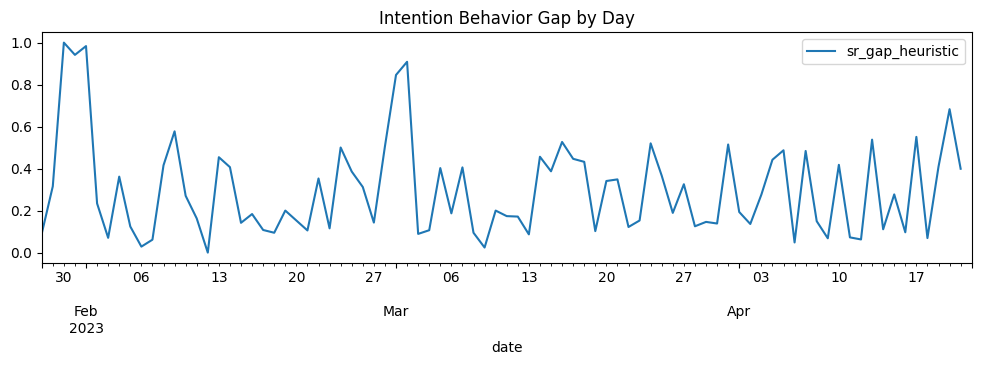

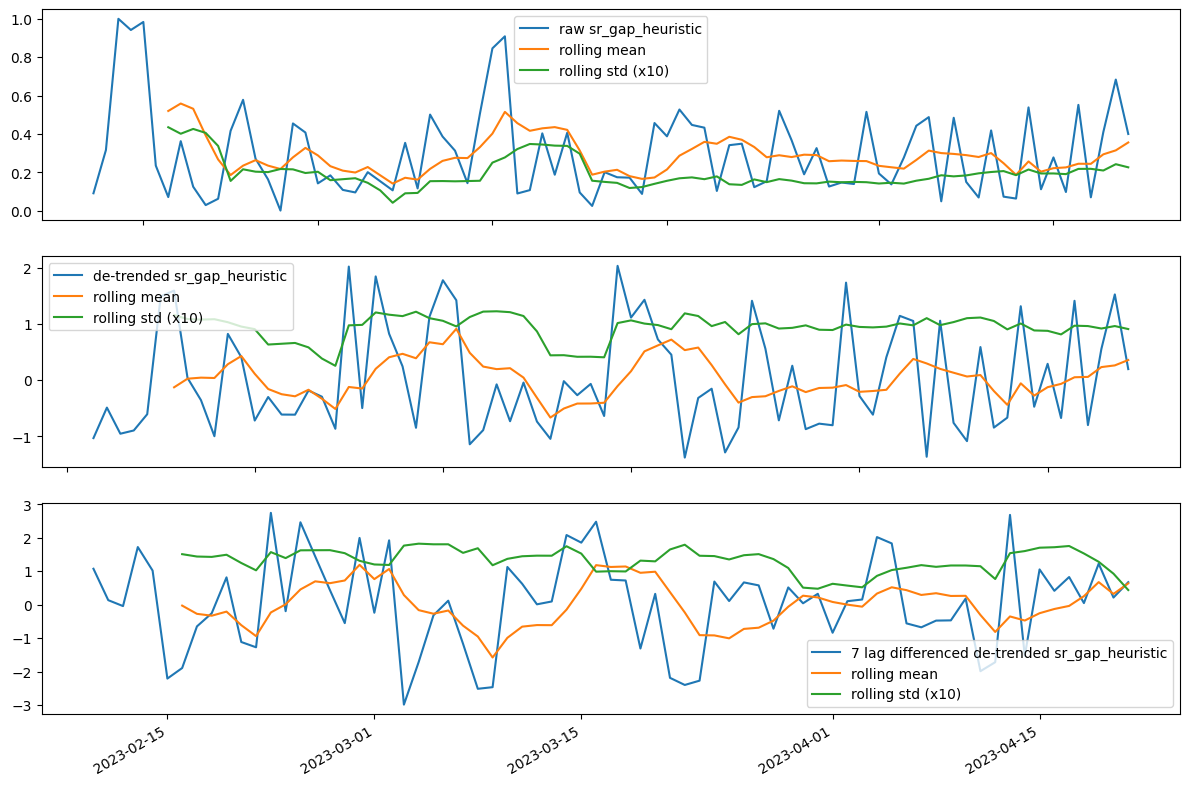

In [164]:
plt.style.use('default')
import matplotlib.dates as mdates

df_sub = pd.DataFrame(df, columns=['date','sr_gap_heuristic']).set_index('date')
df_sub = df_sub.asfreq('D') # Set the frequency to daily
train = df_sub.iloc[:-10, :]
test = df_sub.iloc[-10:, :]
pred = test.copy()
df_sub.plot(figsize=(12,3));
plt.title('Intention Behavior Gap by Day');

df_sub['z_sr_gap_heuristic'] = (df_sub['sr_gap_heuristic'] - df_sub.sr_gap_heuristic.rolling(window=7).mean()) / df_sub.sr_gap_heuristic.rolling(window=7).std()
df_sub['zp_sr_gap_heuristic'] = df_sub['z_sr_gap_heuristic'] - df_sub['z_sr_gap_heuristic'].shift(7)

def plot_rolling(df_sub):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    ax[0].plot(df_sub.index, df_sub.sr_gap_heuristic, label='raw sr_gap_heuristic')
    ax[0].plot(df_sub.sr_gap_heuristic.rolling(window=7).mean(), label="rolling mean");
    ax[0].plot(df_sub.sr_gap_heuristic.rolling(window=7).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df_sub.index, df_sub.z_sr_gap_heuristic, label="de-trended sr_gap_heuristic")
    ax[1].plot(df_sub.z_sr_gap_heuristic.rolling(window=7).mean(), label="rolling mean");
    ax[1].plot(df_sub.z_sr_gap_heuristic.rolling(window=7).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(df_sub.index, df_sub.zp_sr_gap_heuristic, label="7 lag differenced de-trended sr_gap_heuristic")
    ax[2].plot(df_sub.zp_sr_gap_heuristic.rolling(window=7).mean(), label="rolling mean");
    ax[2].plot(df_sub.zp_sr_gap_heuristic.rolling(window=7).std(), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()

plot_rolling(df_sub)

## Traditional

### ARIMA/SARIMA

#### Stationarity

The cleaned time series passed the Augmented Dickey-Fuller (ADF) test, indicating that it is stationary. The test statistic 
−6.73 is well below the critical values, and the very small p-value (3.27×10−9) strongly rejects the null hypothesis of a unit root (non-stationarity).

Given that the data is stationary we can set the integrated term, `d` to 0.

In [165]:
from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(df_sub.sr_gap_heuristic.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(df_sub.z_sr_gap_heuristic.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the 7-lag differenced de-trended data stationary ?")
dftest = adfuller(df_sub.zp_sr_gap_heuristic.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))


 > Is the data stationary ?
Test statistic = -6.733
P-value = 0.000
Critical values :
	1%: -3.5117123057187376 - The data is  stationary with 99% confidence
	5%: -2.8970475206326833 - The data is  stationary with 95% confidence
	10%: -2.5857126912469153 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -8.169
P-value = 0.000
Critical values :
	1%: -3.518281134660583 - The data is  stationary with 99% confidence
	5%: -2.899878185191432 - The data is  stationary with 95% confidence
	10%: -2.5872229937594873 - The data is  stationary with 90% confidence

 > Is the 7-lag differenced de-trended data stationary ?
Test statistic = -4.556
P-value = 0.000
Critical values :
	1%: -3.548493559596539 - The data is  stationary with 99% confidence
	5%: -2.912836594776334 - The data is  stationary with 95% confidence
	10%: -2.594129155766944 - The data is  stationary with 90% confidence


                               SARIMAX Results                                
Dep. Variable:       sr_gap_heuristic   No. Observations:                   84
Model:                          ARIMA   Log Likelihood                   4.483
Date:                Tue, 30 Apr 2024   AIC                             -4.966
Time:                        13:28:16   BIC                             -0.104
Sample:                    01-28-2023   HQIC                            -3.012
                         - 04-21-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2990      0.033      8.930      0.000       0.233       0.365
sigma2         0.0526      0.009      6.137      0.000       0.036       0.069
Ljung-Box (L1) (Q):                   7.10   Jarque-

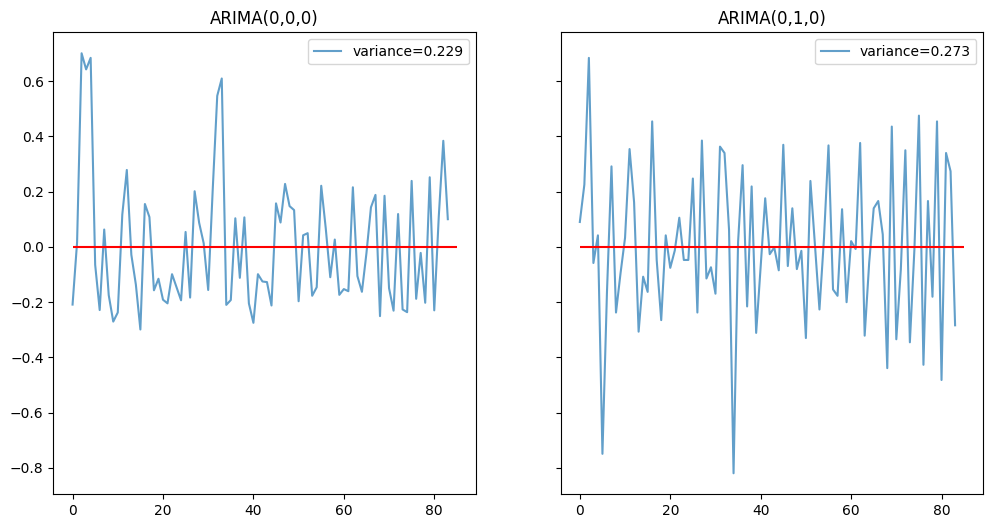

In [166]:
# Alt method for showing stationarity

from statsmodels.tsa.arima.model import ARIMA # this accounts for NaNs

model = ARIMA(df_sub.sr_gap_heuristic.dropna(), order=(0, 0, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(df_sub.sr_gap_heuristic.dropna(), order=(0, 1, 0))
res_010 = model.fit()
print(res_010.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=85, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend();
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=85, color='r');
ax[1].set_title("ARIMA(0,1,0)");
ax[1].legend();

#### Autocorrelation

Given the `PACF` function does not have any significant correlations we can set this value (`p`) to zero


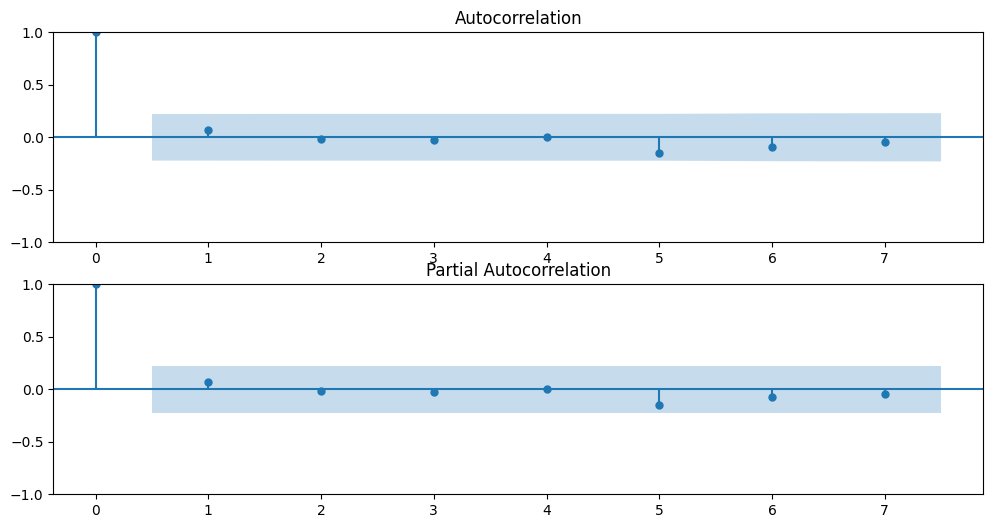

In [167]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df_sub.z_sr_gap_heuristic.dropna(), ax=ax[0], lags=7)
ax[1] = plot_pacf(df_sub.z_sr_gap_heuristic.dropna(), ax=ax[1], lags=7)

#### Predictive Model

The notation ARIMA(p, d, q) represents a specific configuration of the ARIMA model, which stands for AutoRegressive Integrated Moving Average. Let’s break down what each of these parameters represents in the context of ARIMA(1,0,1):

1. **p (AR part) - Autoregressive Term:**
- p = 1: This indicates that the model includes one lag of the series in the prediction. In other words, the model uses the first previous value to predict the current value. This part of the model captures the relationship between a given value and its predecessors.
2. **d (I part) - Integrated Term:**
- d = 0: This specifies the degree of differencing involved. Since d is 0, it means no differencing is needed, suggesting that the time series is already stationary. Differencing is a method of transforming a time series dataset to make it stationary, which is often necessary for ARIMA modeling as it relies on the assumption of stationarity.
3. **q (MA part) - Moving Average Term:**
- q = 1: This indicates that the model uses one moving average term. This part involves the error term of the model’s lagged forecasts. Essentially, it allows the model to account for the relationship between an observation and a residual error from a moving average model applied to lagged observations.

In [168]:
from statsmodels.tsa.arima.model import ARIMA # this accounts for NaNs

p = 0 # autoregressive term
d = 0 # integrated term
q = 0 # moving avearge term

# Split the data into train and test sets for ARIMA model fitting and forecasting
train_size_cleaned = int(len(df) * 0.8)
train_cleaned, test_cleaned = df['sr_gap_heuristic'][:train_size_cleaned], df['sr_gap_heuristic'][train_size_cleaned:]

# Fit the ARIMA model (using ARIMA(X,0,1) as an example configuration)
model_cleaned = ARIMA(train_cleaned, order=(p, d, q))
fitted_model_cleaned = model_cleaned.fit()

# Forecast on the test data
forecast_cleaned = fitted_model_cleaned.forecast(steps=len(test_cleaned))

# Calculate RMSE
mask = ~np.isnan(test_cleaned) & ~np.isnan(forecast_cleaned) # remove NaN values
rmse_cleaned = np.sqrt(mean_squared_error(test_cleaned[mask], forecast_cleaned[mask]))
rmse_cleaned, forecast_cleaned.head()

(0.21179911705509147,
 68    0.304124
 69    0.304124
 70    0.304124
 71    0.304124
 72    0.304124
 Name: predicted_mean, dtype: float64)

In [169]:
# Specify the start date
start_date = '2023-01-01'

# Determine the number of days based on the length of the DataFrame
num_days = len(df)

# Generate the date range
dates = pd.date_range(start=start_date, periods=num_days, freq='D')

In [176]:
dates

DatetimeIndex(['2023-01-28', '2023-01-29', '2023-01-30', '2023-01-31',
               '2023-02-01', '2023-02-02', '2023-02-03', '2023-02-04',
               '2023-02-05', '2023-02-06', '2023-02-07', '2023-02-08',
               '2023-02-09', '2023-02-10', '2023-02-11', '2023-02-12',
               '2023-02-13', '2023-02-14', '2023-02-15', '2023-02-16',
               '2023-02-17', '2023-02-18', '2023-02-19', '2023-02-20',
               '2023-02-21', '2023-02-22', '2023-02-23', '2023-02-24',
               '2023-02-25', '2023-02-26', '2023-02-27', '2023-02-28',
               '2023-03-01', '2023-03-02', '2023-03-03', '2023-03-04',
               '2023-03-05', '2023-03-06', '2023-03-07', '2023-03-08',
               '2023-03-09', '2023-03-10', '2023-03-11', '2023-03-12',
               '2023-03-13', '2023-03-14', '2023-03-15', '2023-03-16',
               '2023-03-17', '2023-03-18', '2023-03-19', '2023-03-20',
               '2023-03-21', '2023-03-22', '2023-03-23', '2023-03-24',
      

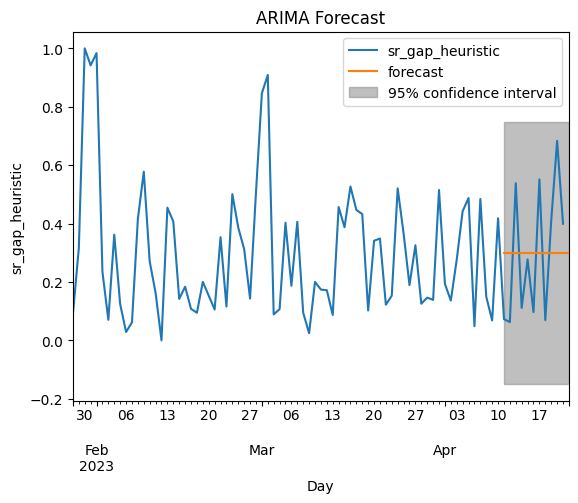

In [177]:
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA

res = ARIMA(df_sub['sr_gap_heuristic'], order=(0,0,0)).fit()

fig, ax = plt.subplots()
ax = df_sub['sr_gap_heuristic'].plot(ax=ax)
plot_predict(res, '2023-04-11', '2023-04-22', ax=ax)
plt.title('ARIMA Forecast')
plt.xlabel('Day')
plt.ylabel('sr_gap_heuristic')
plt.show()

### Exponential Smoothing

In [198]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Forward fill to handle NaNs in the 'sr_gap_heuristic' column
series = df_sub['sr_gap_heuristic'].fillna(method='ffill')

# Model setup
model = SimpleExpSmoothing(series)

# Model fit
model_fit = model.fit()

# Forecast
forecast = model_fit.predict(series)

# RMSE
rmse = np.sqrt(mean_squared_error(series, forecast))
print("RMSE: ", rmse)

TypeError: Cannot convert input [date
2023-01-28    0.090209
2023-01-29    0.315732
2023-01-30    1.000000
2023-01-31    0.941694
2023-02-01    0.983498
                ...   
2023-04-18    0.069307
2023-04-19    0.409241
2023-04-20    0.683168
2023-04-21    0.399340
2023-04-22    0.399340
Freq: D, Name: sr_gap_heuristic, Length: 85, dtype: float64] of type <class 'pandas.core.series.Series'> to Timestamp

In [190]:
test.index

DatetimeIndex(['2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16',
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-22'],
              dtype='datetime64[ns]', name='date', freq='D')

In [193]:
test

,sr_gap_heuristic
date,
2023-04-13,0.537954
2023-04-14,0.111111
2023-04-15,0.277228
2023-04-16,0.096810
2023-04-17,0.551155
2023-04-18,0.069307
2023-04-19,0.409241
2023-04-20,0.683168
2023-04-21,0.399340


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


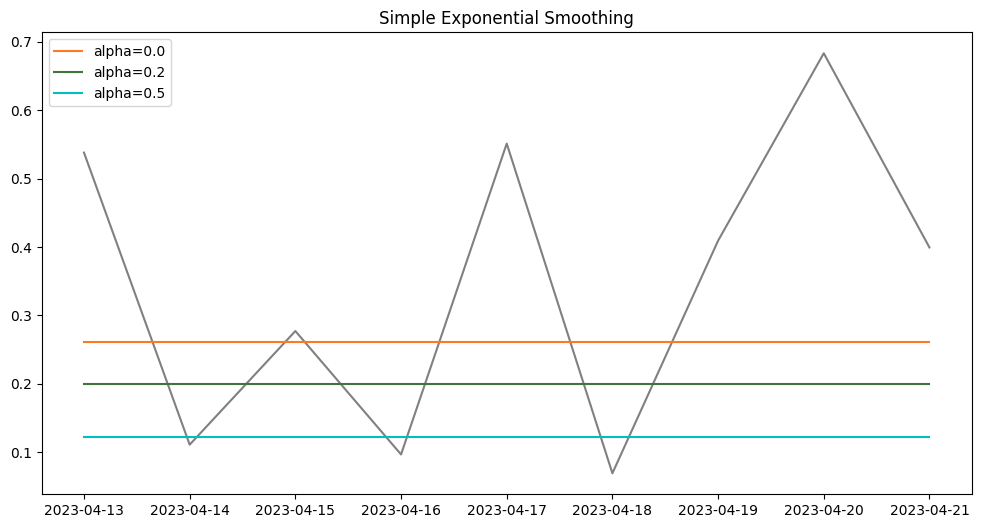

In [196]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

train = df_sub.iloc[7:-10, [0]]
test = df_sub.iloc[-10:, [0]].dropna()
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
pred = test.copy()

model = SimpleExpSmoothing(np.asarray(train['sr_gap_heuristic']))
model._index = pd.to_datetime(train.index)

fit1 = model.fit()
pred1 = fit1.forecast(9)
fit2 = model.fit(smoothing_level=.2)
pred2 = fit2.forecast(9)
fit3 = model.fit(smoothing_level=.5)
pred3 = fit3.forecast(9)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[150:], train.values[150:])
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[150:], f.fittedvalues[150:], color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:3], color=c)
plt.title("Simple Exponential Smoothing")    
plt.legend();
    
# model = Holt(np.asarray(train['sr_gap_heuristic']))
# model._index = pd.to_datetime(train.index)

# fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)
# pred1 = fit1.forecast(9)
# fit2 = model.fit(optimized=True)
# pred2 = fit2.forecast(9)
# fit3 = model.fit(smoothing_level=.3, smoothing_slope=.2)
# pred3 = fit3.forecast(9)

# fig, ax = plt.subplots(figsize=(12, 6))
# ax.plot(train.index[150:], train.values[150:])
# ax.plot(test.index, test.values, color="gray")
# for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
#     ax.plot(train.index[150:], f.fittedvalues[150:], color=c)
#     ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4], color=c)
# plt.title("Holt's Exponential Smoothing")
# plt.legend();

## Machine Learning